<style>
.Yellow{color: Yellow;}
.Black{color: Black;}
.custom-style {
    color: Maroon;
    font-family: sans-serif;
    font-size: 150px;
    text-align: center;
    margin-top: 5px;
    margin-bottom: 5px;
}
</style>
<p class="custom-style">
<span class=Black>De</span><span class=Yellow>X</span><span class=Black>alo</span>
</p>



# Introduction
In this project, I will develop a simple RAG (Retrieval-Augmented Generation) powered by OpenAI model with LangChain. and a calculator tool. also I will develop a frontend using React and FastAPI for the backend. The application will be able to answer questions about the content of a PDF/txt file and perform calculations using a calculator tool. The application will be able to handle multiple files and provide answers based on the content of the files.

## `This Notebook is only to test the tools used in the project.`

# Key Requirements
- The application should be able to answer questions about the content of a PDF/txt file.
- The application should be able to perform calculations using a calculator tool.
- The application should be able to handle multiple files and provide answers based on the content of the files.
- A FastAPI backend
- A React frontend





# Importing Libraries
Any necessary libraries are imported in this section.

In [ ]:
import os
import math
from typing import Type
from pydantic import BaseModel, Field

from langchain.agents import AgentType, initialize_agent
from langchain.tools import BaseTool
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory


from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter
from langchain.vectorstores import FAISS


from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

from llama_parse import LlamaParse
from IPython.display import Markdown


from dotenv import load_dotenv

# Functions Definition & Global Variables
The functions & global or enviroment variables that will be used in the notebook are defined in this section.

In [ ]:
# Set API key
print("OpenAI API Key status:", load_dotenv(dotenv_path=".env"))
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

OpenAI API Key status: True


In [ ]:
# Define a simple calculator tool that our agent can use
class CalculatorInput(BaseModel):
    expression: str = Field(description="Mathematical expression to evaluate")

class CalculatorTool(BaseTool):
    name: str = "calculator"
    description: str = "Useful for performing mathematical calculations"
    args_schema: Type[BaseModel] = CalculatorInput
    
    def _run(self, expression: str) -> str:
        """Evaluate a mathematical expression."""
        try:
            # Add basic math functions to the locals
            local_dict = {
                'sqrt': math.sqrt,
                'pow': pow,
                'abs': abs,
                'round': round,
                'max': max,
                'min': min,
                'sin': math.sin,
                'cos': math.cos,
                'tan': math.tan,
                'pi': math.pi,
                'e': math.e,
                'log': math.log,
                'log10': math.log10,
                'floor': math.floor,
                'ceil': math.ceil
            }
            
            # Evaluate the expression
            result = eval(expression, {"__builtins__": {}}, local_dict)
            return str(result)
        
        except Exception as e:
            return f"Error evaluating expression: {str(e)}"

    async def _arun(self, expression: str) -> str:
        # Async version of _run.
        return self._run(expression)
    


def test_agent(query , agent):
    print(f"\n--- Testing: '{query}' ---")
    response = agent.invoke(input=query)
    print(f"\nFinal response: {response['output']}")
    print("-----------------------------------\n")



# Define a simple function to simulate RAG context
def query_with_context(query, context , agent):
    """Simulate a query with RAG context"""
    enriched_query = (
        f"I have a question that may require information from these documents:\n\n"
        f"{context}\n\n"
        f"My question is: {query}"
    )
    
    print(f"\n--- Testing with RAG context ---")
    print(f"Query: '{query}'")
    print(f"Using context: '{context[:100]}...'")
    
    response = agent.invoke(input=enriched_query)
    
    print(f"\nFinal response: {response['output']}")
    print("-----------------------------------\n")


# LangChain
This section demonstrates how LangChain agents work with tools

## Initialize the language model


In [70]:
llm = ChatOpenAI(temperature=0, model="gpt-4o") # start by using the gpt-3.5-turbo model then switch to gpt-4o if needed or after testing

In [19]:
# test with simple prompt
answer = llm.invoke("What is the capital of France?")
print(answer.content)

The capital of France is Paris.


## Create memory to store chat history

In [9]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

Additional processing may be required in some situations when the conversation history is too large to fit in the context window of the model. 

## Initialize the calculator tool

In [75]:
tool = CalculatorTool()

# test the calculator tool
tool._run("pow((2 + 2), 2)") 

'16'

## Initialize the agent

In [11]:
tools = [CalculatorTool()]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,  # This shows the agent's thought process
    memory=memory
)


## Test the agent with different types of queries


In [30]:
test_agent("What is the square root of 144 plus 5?", agent)



--- Testing: 'What is the square root of 144 plus 5?' ---


> Entering new AgentExecutor chain...
```json
{
    "action": "calculator",
    "action_input": "sqrt(144) + 5"
}
```
Observation: 17.0
Thought:```json
{
    "action": "Final Answer",
    "action_input": "17.0"
}
```

> Finished chain.

Final response: 17.0
-----------------------------------



In [32]:
test_agent("Tell me about the weather today" , agent)


--- Testing: 'Tell me about the weather today' ---


> Entering new AgentExecutor chain...
```json
{
    "action": "Final Answer",
    "action_input": "I'm an AI assistant and do not have real-time information. You can check the weather using a weather website or app for the most up-to-date information."
}
```

> Finished chain.

Final response: I'm an AI assistant and do not have real-time information. You can check the weather using a weather website or app for the most up-to-date information.
-----------------------------------



In [34]:
test_agent("If I have 3 apples and each costs $2.50, and I also buy 2 oranges at $1.75 each, how much will I spend in total?" , agent)



--- Testing: 'If I have 3 apples and each costs $2.50, and I also buy 2 oranges at $1.75 each, how much will I spend in total?' ---


> Entering new AgentExecutor chain...
```json
{
    "action": "calculator",
    "action_input": "3 * 2.50 + 2 * 1.75"
}
```
Observation: 11.0
Thought:```json
{
    "action": "Final Answer",
    "action_input": "11.0"
}
```

> Finished chain.

Final response: 11.0
-----------------------------------



## RAG Simulation

In [38]:
# Sample context that simulates retrieved document chunks from my CV
sample_context = """Projects: 
 Wireless Chess Robotic Arm (WCRA-AI)  Graduation Project. Grade: Excellent.  
▪ Designed & built a chess-playing robotic arm utilizing CNN and IoT with two operation modes. 
▪ Implemented strategic decision-making using the NegaMax search algorithm on a Raspberry Pi. 
▪ Guide search algorithm with efficiently updatable neural network (NNUE) as evaluation function. 
▪ Integrated computer vision for gameplay & data collection to train CNN. Kaggle 
 AI Model Testing & Reporting (NLP  Computer Vision) (Individual) 
▪ Extracted CAMeLBERT sentiment analysis strengths, drawbacks & potential use cases in a report. 
▪ Extracted FaceNet512 strengths & drawbacks through challenging selective examples in a report. 
 Quantity Forecasting Across Different Products & Cities (Time Series) (Individual). 
▪ Data exploration, visualization, preprocessing & feature engineering. 
▪ Time series cross-validation Modeling (Exponential smoothing, ARIMA, Prophet, & LSTM). 
▪ Tailor a new zero-aware error metric to suit the problem & squeeze performance using N-BEATS. 
 Enhanced Valuation of Personal Injury Claims (Omdena Project) Demo. 
▪ Collaborated with an international team to develop a predictive model for injury claims. 
▪ Data collection, analysis, visualization, and preprocessing. 
▪ Applied machine learning techniques to improve transparency and accuracy in legal processes. 
 AI Research Assistant (CrewAI) (individual). 
▪ Multi-agent AI system to help researchers identify trends and research gaps. 
▪ 3 specialized AI agents to conduct comprehensive research & a user-friendly Streamlit app. 
▪ Utilize APIs to access the latest research papers and tech news to guide the next research steps. 
"""

# Test with context
query_with_context("What was my graduation project?", sample_context , agent)


--- Testing with RAG context ---
Query: 'What was my graduation project?'
Using context: 'Projects: 
 Wireless Chess Robotic Arm (WCRA-AI)  Graduation Project. Grade: Excellent.  
▪ Designe...'


> Entering new AgentExecutor chain...
```json
{
    "action": "Final Answer",
    "action_input": "Wireless Chess Robotic Arm (WCRA-AI) Graduation Project. Grade: Excellent. Designed & built a chess-playing robotic arm utilizing CNN and IoT with two operation modes. Implemented strategic decision-making using the NegaMax search algorithm on a Raspberry Pi. Guide search algorithm with efficiently updatable neural network (NNUE) as evaluation function. Integrated computer vision for gameplay & data collection to train CNN. Kaggle"
}
```

> Finished chain.

Final response: Wireless Chess Robotic Arm (WCRA-AI) Graduation Project. Grade: Excellent. Designed & built a chess-playing robotic arm utilizing CNN and IoT with two operation modes. Implemented strategic decision-making using the NegaMax s

# RAG (Retrieval-Augmented Generation) System

## Token Text Splitter

In [ ]:
# Initialize the Token Text Splitter for chunking
text_splitter = TokenTextSplitter(
    chunk_size=200,  
    chunk_overlap=50
)

# Load and split the document
loader = PyPDFLoader("../Attention is All you Need - Ashish Vaswani, Noam Shazeer, N.pdf")
documents = loader.load()
chunks = text_splitter.split_documents(documents)

print(f"Split document into {len(chunks)} chunks")
print("\nSample chunks:")
for i, chunk in enumerate(chunks[:5]):  # Show first 3 chunks
    print(f"\nChunk {i+1}:")
    print(f"Content: {chunk.page_content[:100]}...")
    print(f"Metadata: {chunk.metadata}")


Split document into 60 chunks

Sample chunks:

Chunk 1:
Content: Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brai...
Metadata: {'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'author': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin', 'book': 'Advances in Neural Information Processing Systems 30', 'created': '2017', 'date': '2017', 'description': 'Paper accepted and presented at the Neural Information Processing Systems Conference (http://nips.cc/)', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions

## Semantic Chunking

In [ ]:
# Initialize the Token Text Splitter for chunking
text_splitter = SemanticChunker(OpenAIEmbeddings())

# Load and split the document
loader = PyPDFLoader("Mohamed Motaz CV.pdf")
documents = loader.load()
chunks = text_splitter.split_documents(documents)

print(f"Split document into {len(chunks)} chunks")
print("\nSample chunks:")
for i, chunk in enumerate(chunks[:5]):  # Show first 3 chunks
    print(f"\nChunk {i+1}:")
    print(f"Content: {chunk.page_content[:100]}...")
    print(f"Metadata: {chunk.metadata}")

Split document into 5 chunks

Sample chunks:

Chunk 1:
Content: Mohamed Moataz 
Phone: (+20) 1120682864             
Email:  mohamad.motaz.mostafa@gmail.com             
LinkedIn: mohamed-moataz 
Military Status: Completed. Professional Summary:  
Data Scientist with a strong foundation in mathematics and experience in developing and deploying AI 
models....
Metadata: {'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-04-10T19:58:19+02:00', 'author': 'Win 10', 'moddate': '2025-04-10T19:58:19+02:00', 'source': 'Mohamed Motaz CV.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}

Chunk 2:
Content: Proven abilities in data exploration, machine learning, and software development. Passionate 
about advancing AI & ML technologies, scientific research, and contributing to innovative projects. Education: 
AI & ML 9-month Diploma - Information Technology Institute (ITI)  
- Supervised by the Ministry of Communication to lea

## Embeddings and vector store

In [7]:
embeddings = OpenAIEmbeddings()
vector_store = FAISS.from_documents(chunks, embeddings)

In [9]:
vector_store.save_local("faiss_index")

In [11]:
vector_store = FAISS.load_local("faiss_index", embeddings , allow_dangerous_deserialization=True)

In [33]:
vector_store.docstore._dict.values().mapping.values().mapping.values()

dict_values([Document(id='d5d9b014-d5cc-4120-b188-81f1e0a95675', metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-04-10T19:58:19+02:00', 'author': 'Win 10', 'moddate': '2025-04-10T19:58:19+02:00', 'source': 'Mohamed Motaz CV.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='Mohamed Moataz \nPhone: (+20) 1120682864             \nEmail:  mohamad.motaz.mostafa@gmail.com             \nLinkedIn: mohamed-moataz \nMilitary Status: Completed.\nProfessional Summary:  \nData Scientist with a strong foundation in mathematics and experience in developing and deploying AI \nmodels. Proven abilities in data exploration, machine learning, and software development. Passionate \nabout advancing AI & ML technologies, scientific research, and contributing to innovative projects. \nEducation: \nAI & ML 9-month Diploma - Information Technology Institute (ITI)  \n- Supervised by the Ministry of Communication t

In [34]:
# Number of chunks/vectors in your database
num_chunks = len(vector_store.index_to_docstore_id)
print(f"Total chunks in database: {num_chunks}")



Total chunks in database: 8


In [38]:
# Create a summary of documents and their chunks
doc_summary = {}

# Iterate through all documents in the docstore
for doc_id, doc in vector_store.docstore._dict.items():
    source = doc.metadata.get('source', 'unknown')
    
    if source not in doc_summary:
        doc_summary[source] = 0
    doc_summary[source] += 1

# Print document summary
print("\nDocument Summary:")
for source, count in doc_summary.items():
    print(f"- {source}: {count} chunks")


Document Summary:
- Mohamed Motaz CV.pdf: 8 chunks
- ../Attention is All you Need - Ashish Vaswani, Noam Shazeer, N.pdf: 60 chunks


In [ ]:
def search_documents(query: str, k: int = 3):
    """Search for relevant document chunks."""
    print(f"\n--- Searching for: '{query}' ---")
    results = vector_store.similarity_search(query, k=k)
    
    print(f"Found {len(results)} relevant chunks:")
    for i, doc in enumerate(results):
        print(f"\nResult {i+1}:")
        print(f"Content: {doc.page_content}")
        print(f"Similarity: Present in top {k} results")
    
    return results

In [56]:
search_documents("What is my email addres?" , 1 )



--- Searching for: 'What is my email addres?' ---
Found 1 relevant chunks:

Result 1:
Content: Mohamed Moataz 
Phone: (+20) 1120682864             
Email:  mohamad.motaz.mostafa@gmail.com             
LinkedIn: mohamed-moataz 
Military Status: Completed. Professional Summary:  
Data Scientist with a strong foundation in mathematics and experience in developing and deploying AI 
models.
Similarity: Present in top 1 results


[Document(id='7d203892-c789-4395-8f5e-253473905564', metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-04-10T19:58:19+02:00', 'author': 'Win 10', 'moddate': '2025-04-10T19:58:19+02:00', 'source': 'Mohamed Motaz CV.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='Mohamed Moataz \nPhone: (+20) 1120682864             \nEmail:  mohamad.motaz.mostafa@gmail.com             \nLinkedIn: mohamed-moataz \nMilitary Status: Completed. Professional Summary:  \nData Scientist with a strong foundation in mathematics and experience in developing and deploying AI \nmodels.')]

# RAG

In [ ]:
def answer_with_rag_and_agent(query: str):
    """Process a query using RAG + agent."""
    print(f"\n--- Processing query with RAG + Agent: '{query}' ---")
    
    # Retrieve relevant documents
    relevant_docs = search_documents(query, k=1)
    context_text = "\n\n".join([doc.page_content for doc in relevant_docs])
    
    # Enrich the query with context
    enriched_query = (
        f"I have a question that may require information from these documents:\n\n"
        f"{context_text}\n\n"
        f"My question is: {query}"
    )
    
    # Process with the agent
    print("\nSending to agent with context...")
    response = agent.invoke(input=enriched_query)
    
    print(f"\nFinal response: {response['output']}")
    print("-----------------------------------\n")
    
    return response['output']


In [62]:
answer_with_rag_and_agent("What is my email addres?")



--- Processing query with RAG + Agent: 'What is my email addres?' ---

--- Searching for: 'What is my email addres?' ---
Found 1 relevant chunks:

Result 1:
Content: Mohamed Moataz 
Phone: (+20) 1120682864             
Email:  mohamad.motaz.mostafa@gmail.com             
LinkedIn: mohamed-moataz 
Military Status: Completed. Professional Summary:  
Data Scientist with a strong foundation in mathematics and experience in developing and deploying AI 
models.
Similarity: Present in top 1 results

Sending to agent with context...


> Entering new AgentExecutor chain...
```json
{
    "action": "Final Answer",
    "action_input": "mohamad.motaz.mostafa@gmail.com"
}
```

> Finished chain.

Final response: mohamad.motaz.mostafa@gmail.com
-----------------------------------



'mohamad.motaz.mostafa@gmail.com'

In [64]:
answer_with_rag_and_agent("what was my ranking in QTech hakathon?")


--- Processing query with RAG + Agent: 'what was my ranking in QTech hakathon?' ---

--- Searching for: 'what was my ranking in QTech hakathon?' ---
Found 1 relevant chunks:

Result 1:
Content: All certifications are available upon request. GitHub 
Hackathons: 
Q-tech & ITI Hackathon 
Ranked 3rd place among 15 different teams from ITI graduation projects. Certificate  
Certifications
 Intermediate Machine Learning, Kaggle.
Similarity: Present in top 1 results

Sending to agent with context...


> Entering new AgentExecutor chain...
```json
{
    "action": "Final Answer",
    "action_input": "Ranked 3rd place among 15 different teams from ITI graduation projects."
}
```

> Finished chain.

Final response: Ranked 3rd place among 15 different teams from ITI graduation projects.
-----------------------------------



'Ranked 3rd place among 15 different teams from ITI graduation projects.'

## LlamaParse
pros:
- Llama parse can increase the performance of the RAG system by chunking the text into smaller pieces and creating embeddings for each chunk. This allows the model to retrieve relevant information more efficiently and accurately. Llama parse can also help in reducing the size of the vector store, making it easier to manage and query. <br>

cons:
- Llama parse can be computationally expensive and may require additional resources to run. It also can increase cost if used with openai models. <br>

In [ ]:
parser = LlamaParse(
    result_type="markdown",
    model=llm,
)

llama_parse_documents = await parser.aload_data("Mohamed Motaz CV.pdf")

In [ ]:
Markdown(llama_parse_documents[0].text)

# Mohamed Moataz

Phone: (+20) 1120682864

LinkedIn: mohamed-moataz

Email: mohamad.motaz.mostafa@gmail.com

Military Status: Completed.

# Professional Summary:

Data Scientist with a strong foundation in mathematics and experience in developing and deploying AI models. Proven abilities in data exploration, machine learning, and software development. Passionate about advancing AI & ML technologies, scientific research, and contributing to innovative projects.

# Education:

AI & ML 9-month Diploma - Information Technology Institute (ITI)

- Supervised by the Ministry of Communication to learn AI and ML through practical projects.

Bachelor of Engineering in Computer & Communication Engineering (2017) GPA: 3.05

# Work Experience & Internships:

Freelancer – Upwork

AI Developer – SWIFT ACT

- Design and develop a local RAG system (Chatbot) using Llama 3.
- Design and develop an Exam Grading tool.

# Projects:

Wireless Chess Robotic Arm (WCRA-AI) – Graduation Project. Grade: Excellent.

- Designed & built a chess-playing robotic arm utilizing CNN and IoT with two operation modes.
- Implemented strategic decision-making using the NegaMax search algorithm on a Raspberry Pi.
- Guide search algorithm with efficiently updatable neural network (NNUE) as evaluation function.
- Integrated computer vision for gameplay & data collection to train CNN.

AI Model Testing & Reporting (NLP – Computer Vision) (Individual)

- Extracted CAMeLBERT sentiment analysis strengths, drawbacks & potential use cases in a report.
- Extracted FaceNet512 strengths & drawbacks through challenging selective examples in a report.

Quantity Forecasting Across Different Products & Cities (Time Series) (Individual).

- Data exploration, visualization, preprocessing & feature engineering.
- Time series cross-validation Modeling (Exponential smoothing, ARIMA, Prophet, & LSTM).
- Tailor a new zero-aware error metric to suit the problem & squeeze performance using N-BEATS.

Enhanced Valuation of Personal Injury Claims (Omdena Project) Demo.

- Collaborated with an international team to develop a predictive model for injury claims.
- Data collection, analysis, visualization, and preprocessing.
- Applied machine learning techniques to improve transparency and accuracy in legal processes.

AI Research Assistant (CrewAI) (individual).

- Multi-agent AI system to help researchers identify trends and research gaps.
- 3 specialized AI agents to conduct comprehensive research & a user-friendly Streamlit app.
- Utilize APIs to access the latest research papers and tech news to guide the next research steps.

Credit Card Data Clustering (Unsupervised Machine Learning) (Individual).

- Data Preprocessing & Investigation.
- Apply Clustering Algorithms: K-Means, Hierarchical Clustering, DBSCAN.
- Apply PCA and Kernel PCA, and Visualization using t-SNE.

# Technical Skills:

- Programming Languages: Python, C, C++, MATLAB, SQL, NoSQL.
- Machine & Deep Learning: Scikit-Learn, TensorFlow, Keras, PyTorch, OpenCV, CrewAI.
- Data Analysis & Visualization: Pandas, NumPy, PySpark, Plotly, Matplotlib, Seaborn.
- Software Engineering: Strong background in OOP, data structures, algorithms, Linux, and CI/CD.

In [56]:
Markdown(llama_parse_documents[1].text)


# Hackathons:

# Q-tech & ITI Hackathon

Ranked 3ʳᵈ place among 15 different teams from ITI graduation projects. Certificate

# Certifications

- Intermediate Machine Learning, Kaggle.
- Data Analysis Challenger, Udacity.
- AI & Problem-solving, IEEE-MYT.
- Multi AI Agent Systems with CrewAI, deeplearning.ai.
- Azure AI fundamentals, Microsoft.
- AWS Cloud Foundations, AWS Academy.
- CCNA v7, NTI.

# Volunteering Work:

# Student Union

- Orphan's Day party - Organizer.
- Feek El-kheer, Ramadan.
- Newcomer’s Day - Organizer.
- Organizing Nursing home visits.

# Dream Family Student Activity

- Head of Science Committee.
- Social media coverage specialist.
- Trip Organizer.
- Dream Family Leader.

All certifications are available upon request.

GitHub

---
## It also can extract images and tables from the PDF. <br>

In [91]:
llama_parse_documents = await parser.aload_data("../ML Model Answer[1].pdf")

Started parsing the file under job_id e854790b-5a9d-41a1-9a53-7b9d8ef152f7


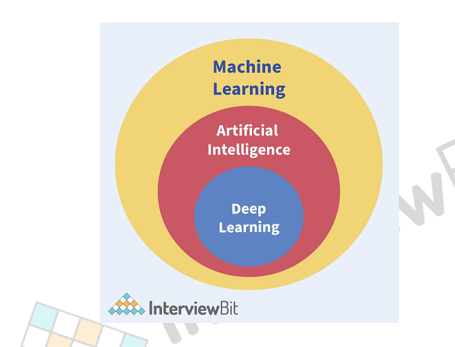

In [94]:
Markdown(llama_parse_documents[9].text)


# Artificial Intelligence Interview Questions

# Machine Learning

# Artificial Intelligence

# Deep Learning

InterviewBit

Page 9

© Copyright by Interviewbit

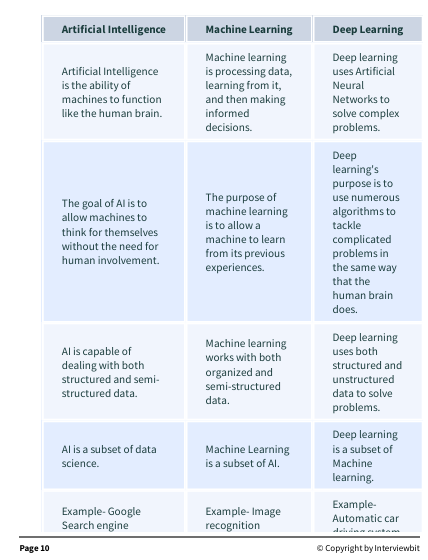

In [95]:
Markdown(llama_parse_documents[10].text)


# Artificial Intelligence Interview Questions

# Artificial Intelligence

Artificial Intelligence is the ability of machines to function like the human brain. The goal of AI is to allow machines to think for themselves without the need for human involvement. AI is capable of dealing with both structured and semi-structured data. AI is a subset of data science.

# Machine Learning

Machine learning is processing data, learning from it, and then making informed decisions. The purpose of machine learning is to allow a machine to learn from its previous experiences. Machine learning works with both organized and semi-structured data. Machine Learning is a subset of AI.

# Deep Learning

Deep learning uses Artificial Neural Networks to solve complex problems. Deep learning's purpose is to use numerous algorithms to tackle complicated problems in the same way that the human brain does. Deep learning uses both structured and unstructured data to solve problems. Deep learning is a subset of Machine learning.

# Examples

Example- Google Search engine
Example- Image recognition
Example- Automatic car driving system

Page 10

© Copyright by Interviewbit

# Conclusion
In this notebook, we have demonstrated how to build a simple RAG system using LangChain and OpenAI models. We have also shown how to use the calculator tool and how to handle multiple files. The application can answer questions about the content of the files and perform calculations using the calculator tool. The application is built using FastAPI for the backend and React for the frontend. The RAG system can be further improved by using LlamaParse for chunking and creating embeddings for each chunk, or we can use this approch from [OpenAi Cookbook](https://cookbook.openai.com/examples/parse_pdf_docs_for_rag) which is simmilar to LamaParse. <br>